# Detecting Emotions in News Headlines

### Part II: Models

Kelly Epley

![emoticons](images/smiley-1041796_1280.jpg)

This notebook documents techiniques used to identify the emotions present in news headlines.

The dataset contains 1,250 headlines from a variety of news sources. Each is rated for six emotion categories: anger, disgust, fear, joy, sadness, and suprise. 

I used multilabel classification techniques from skmultilearn and keras to generate a prediction model that can detect the presence of each of the six emotion labels.

### Collecting Packages

In [34]:
# basic packages
import pandas as pd
import numpy as np
import itertools
import random
import pickle

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance 
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.model_selection import GridSearchCV

# rnn
from gensim.models import KeyedVectors
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Preprocessing Data and Labels

I used a custom preprocessing class to prepare my text data, which:
* converts all text to lower case
* removes punction(except for exclamation points and question marks, which are emotion relevant) 
* removes numeric characters
* removes stopwords
* lemmatizes words (converts to root words)

The stopwords list is a modified version of [this]('https://algs4.cs.princeton.edu/35applications/stopwords.txt') one. I removed words that are relevant to emotion-identification such as ....

The emotion dataframe contains ratings for each emotion. I added a max rating column during data exploration. I also added label columns, which are populated with ones and zeros. A one indicates that the emotion is present (it has a non-zero rating), A zero indicates that it is not.  

In [35]:
# use custom function to get the corpus df and emotion labels 
corpus_df, emotion_df, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [36]:
# inspect corpus
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [37]:
# inspect labels
emotion_df.head()


,anger,disgust,fear,joy,sadness,suprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,suprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


### Multilabel Classification Evaluation Metrics

I've compiled evaluation metrics in two functions. One is for evaluating how a model performs with respect to each individual emotion label. The other is a set of summary scores useful for comparing a model's overall performace.

##### Individual emotion labels

I use confusion matrices to display predicted labels vs. actual labels.

To compare performace on individual labels, I use accuracy, precision, recall, and f1 scores.

* Accuracy score tells us the ratio of correct predictions to total predictions 

* Precision score tells us the ratio of correct predictions to total predictions of the target class 

* Recall score tells us the ratio of correct predictions to the total true cases of the taget class

* F1 is a weighted average of precision and recall

I include all four of these metrics because the emotion labels are, to varying degress, imbalanced. There are unequal ratios of headlines with the emotion present and headlines with the emotion absent. Because the labels are imbalanced, accuracy is not always diagnostic on its own. The most imbalanced label is suprise, which is present in 88% of headlines in the dataset. When a label is imbalanced, it's necessary to look at F1 and its components, precision and recall, to see whether the model can identify both presence and absence of the emotion correctly.


In [38]:
def label_scores(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,10))
    subplot_num = 1
    
    # calculate true positives, false positives, false negatives, and true negatives
    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        # plot confusion matrix
        plt.subplot(2,3,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        # calculate and print accuracy, precision, recall, and f1
        accuracy = tp/(fp + tn + tp + fn)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * ((precision * recall) / (precision + recall))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", f1)
        print('\n')

        

##### Overall Performance

To evaluate a model's performance on the whole set of possible labels, I compare jaccard similarity, hamming loss, and f1 macro scores.

* Jaccard Similarity is the ratio of correct labels to total predictions.
* Hamming Loss is the ratio of incorrect labels to total predictions.
* F1 Macro is an mean of f1 scores (see above) for all labels.

Note that Jaccard Similarity and Hamming loss both count the correct or incorrect labels for each individual label and add them together. I use these metrics rather than ones requiring a perfect match across all labels because it's useful to know whether a model can predict subsets of the correct labels at a higher rate than others. This requires metrics that do not treat a prediction that gets five out of six labels correct the same as one that gets zero out of six correct.

In [39]:
def overall_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_macro = jaccard_score(y_true, y_pred, average='macro')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    
    print('jaccard score macro:', round(jaccard_score_macro, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    

### Train-Test Split

I split the data into training and testing sets using skmultilearn's iterative_train_test_split. This ensures that using iterative_train_test_split labels are distributed as evenly as possibile.

In [40]:
# Split the data into separate training and testing sets 
random.seed(22)
X_train, y_train, X_test, y_test = iterative_train_test_split(corpus_df.values, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'suprise_label']].values, test_size=.25)

# Check to see that the labels are evenly divided
print('Percent of each label appreaing in the test set:')
print("   Anger:", y_test[:,0].sum()/(y_test[:,0].sum()+y_train[:,0].sum()))
print("   Disgust:", y_test[:,1].sum()/(y_test[:,1].sum()+y_train[:,1].sum()))
print("   Fear:", y_test[:,2].sum()/(y_test[:,2].sum()+y_train[:,2].sum()))
print("   Joy:", y_test[:,3].sum()/(y_test[:,3].sum()+y_train[:,3].sum()))
print("   Sadness", y_test[:,4].sum()/(y_test[:,4].sum()+y_train[:,4].sum()))
print("   Suprise:", y_test[:,5].sum()/(y_test[:,5].sum()+y_train[:,5].sum()))


Percent of each label appreaing in the test set:
   Anger: 0.24386503067484663
   Disgust: 0.25333333333333335
   Fear: 0.24634146341463414
   Joy: 0.24936386768447838
   Sadness 0.23638470451911936
   Suprise: 0.24682395644283123


### TF-IDF Vectorization

The data needs to be transformed into a numeric format before it can be used to train a model. 

One option is to use a "Bag of Words" representation of the text. By this [method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), each document is represented by a count for each word that is present. 

As an example, I'll use the opening lines of Dickens's *Tale of Two Cities*: "It was the best of times, it was the worst of times" and "It was the age of wisdom, it was the age of foolishness."

Each row is a document and each column is a word in the corpus.

| it | was | the | best | of | times | worst | age | wisdom | foolishness |  
|----|-----|-----|------|----|-------|-------|-----|--------|-------------|
|2   |2    |2    |1     |2   |2      |1      |0    |0       |0            |
|2   |2    |2    |0     |2   |0      |1      |2    |1       |1            |

Another option is to use term frequency - inverse document frequency (TF-IDF). TF-IDF is a representation of how import a word is in distinguishing a document from other documents in the corpus. The higher the score, the more important the word.

It's calculated by multiplying term frequency by inverse document frequency.

* Term Frequency: times the word appears in the document/number of words in the document

* Inverse Document Frequency: log(number of documents in the corpus/number documents in the corpus in which the word appears)

Here's how it looks on the whole document example:

| it | was | the | best | of | times | worst | age | wisdom | foolishness |  
|----|-----|-----|------|----|-------|-------|-----|--------|-------------|
|0   |0    |0    |.06   |0   |.12    |.06    |0    |0       |0            |
|0   |0    |0    |0     |0   |0      |0      |.12  |.06     |.06          |

Using TF-IDF keeps models from treating words that aren't distinguishing to a document as significant in determining whether other documents should have the same label.

In [41]:
# flatten X_train and X_test
X_train_flat = []
for i in X_train:
    for j in i:
        X_train_flat.append(j)

X_test_flat = []
for i in X_test:
    for j in i:
        X_test_flat.append(j)

# Use TfidVectorizer to get a sparse matrix of TF-IDF scores for each word in the corpus.
# Fit to training data and then use it to transform the test data.
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(pd.DataFrame({'text':X_train[:,0]})['text'])
X_test = vectorizer.transform(pd.DataFrame({'text': X_test[:,0]})['text'])


### Baseline: Binary Relevance Classification Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is some moderate correlation between the labels in my dataset.

![correlations](images/emotion_correlations.png)

My baseline model assumes that they are independent. I used Binary Relevance Classification model with a Logistic Regression estimator. 

Binary Relevance trains a separate model for each label in the dataset. Each model's predictions are independent of all the others.


In [42]:
# Fit data to a Binary Relevance classifier with a Logisitic Regression estimator
LR = LogisticRegression()
BR = BinaryRelevance(LR)
BR.fit(X_train, y_train)

BinaryRelevance(classifier=LogisticRegression(C=1.0, class_weight=None,
                                              dual=False, fit_intercept=True,
                                              intercept_scaling=1,
                                              l1_ratio=None, max_iter=100,
                                              multi_class='warn', n_jobs=None,
                                              penalty='l2', random_state=None,
                                              solver='warn', tol=0.0001,
                                              verbose=0, warm_start=False),
                require_dense=[True, True])

In [43]:
# Predict on the training and test sets
BR_train_preds = BR.predict(X_train).toarray()
BR_test_preds = BR.predict(X_test).toarray()

emotion_pred_labels = ['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_suprise_label']
emotion_labels = ['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'suprise_label']

# Create a prediction df
BR_preds_df = pd.DataFrame(BR_test_preds, columns=emotion_pred_labels)
y_test_df = pd.DataFrame(y_test, columns=emotion_labels)
BR_preds_df = pd.concat([BR_preds_df, y_test_df], axis=1)

In [44]:
# Get BR Train Scores
overall_scores(y_train, BR_train_preds)

jaccard score macro: 0.83
hamming loss: 0.129
f1 macro: 0.906


In [45]:
# get BR Overall Test Scores
overall_scores(y_test, BR_test_preds)

jaccard score macro: 0.669
hamming loss: 0.25
f1 macro: 0.793


anger_label accuracy: 0.4243421052631579
anger_label precision: 0.7371428571428571
anger_label recall 0.8113207547169812
anger_label f1 0.7724550898203593


disgust_label accuracy: 0.20065789473684212
disgust_label precision: 0.8243243243243243
disgust_label recall 0.45864661654135336
disgust_label f1 0.5893719806763285


fear_label accuracy: 0.6611842105263158
fear_label precision: 0.6955017301038062
fear_label recall 0.995049504950495
fear_label f1 0.8187372708757638


joy_label accuracy: 0.6085526315789473
joy_label precision: 0.72265625
joy_label recall 0.9438775510204082
joy_label f1 0.8185840707964602


sadness_label accuracy: 0.6677631578947368
sadness_label precision: 0.6904761904761905
sadness_label recall 0.9950980392156863
sadness_label f1 0.8152610441767069


suprise_label accuracy: 0.8947368421052632
suprise_label precision: 0.8947368421052632
suprise_label recall 1.0
suprise_label f1 0.9444444444444444




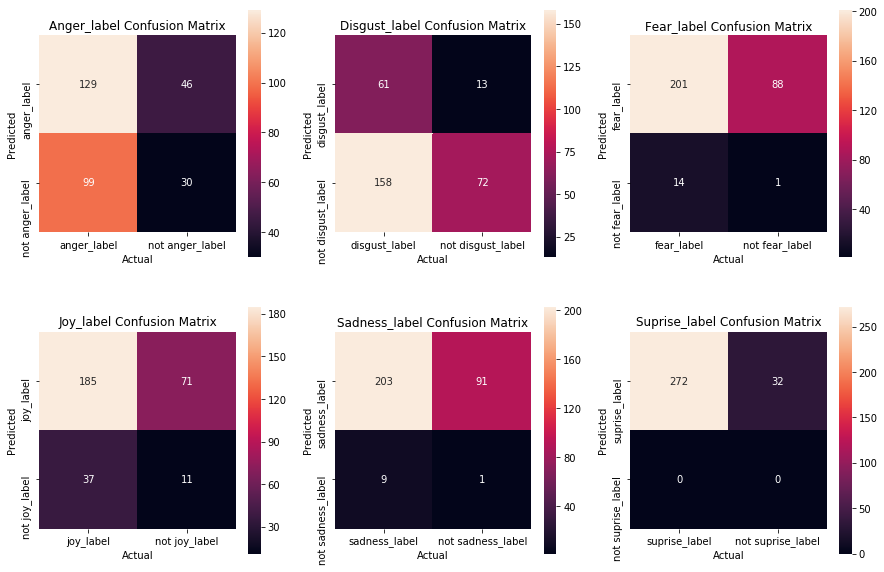

In [46]:
# Get BR Label Test Scores 
label_scores(emotion_labels, BR_preds_df)

### Compare: Classifier Chain

Since there is moderate correlation among the emotion labels, I compared my Binary Relevance Classifier to a Classifier Chain. A Classifier Chain sequentially trains a model for each label in the dataset, and each model's predictions are transferred to the next model. This allows probabistic relationships between labels to have an impact on the model's predictions.

Classifiers Chains are sensitive to label order, so I tested all 750 possible label orders to find the best one. If my dataset were significantly larger or if I had significantly more label combinations to test, this would have been too computationally expensive, and it would have been more practical to do a random selection of label orders to test. 

The Classifier Chain and the Binary Relevance model perform roughly the same in terms of their overall scores, but note that the classifier chain does better with respect to disgust, which is the least common label and hence the most difficult to for models to capture. Also note that neither model predicts that any headline does not contain suprise. This can happen with labels that are overrepresented in a dataset because the prior probability of something's having that label is so high that the model always predicts it regardless of the evidence. I will address this problem using class weights in the final model.


In [52]:
perms = list(itertools.permutations([0,1,2,3,4,5]))

chains = [ClassifierChain(LR, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(X_train, y_train)
    test_preds = chain.predict(X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='micro'))

In [53]:
# Fit the training data on the Chain Classifier with the best label order
CC_best_order = chains[results_jaccard.index(max(results_jaccard))].fit(X_train, y_train)

# Predict on the training and test sets
CC_train_preds = CC_best_order.predict(X_train).toarray()
CC_test_preds = CC_best_order.predict(X_test).toarray()

# Create a test prediction df
CC_preds_df = pd.DataFrame(CC_test_preds, columns=emotion_pred_labels)
CC_preds_df = pd.concat([CC_preds_df, y_test_df], axis=1)

In [54]:
# Get CC Train Scores
overall_scores(y_train, CC_train_preds)

jaccard score macro: 0.805
hamming loss: 0.135
f1 macro: 0.888


In [55]:
# Get CC Test Scores
overall_scores(y_test, CC_test_preds)

jaccard score macro: 0.655
hamming loss: 0.253
f1 macro: 0.784


anger_label accuracy: 0.4243421052631579
anger_label precision: 0.7371428571428571
anger_label recall 0.8113207547169812
anger_label f1 0.7724550898203593


disgust_label accuracy: 0.32894736842105265
disgust_label precision: 0.5847953216374269
disgust_label recall 0.7518796992481203
disgust_label f1 0.6578947368421052


fear_label accuracy: 0.5526315789473685
fear_label precision: 0.8155339805825242
fear_label recall 0.8316831683168316
fear_label f1 0.8235294117647058


joy_label accuracy: 0.3684210526315789
joy_label precision: 0.8175182481751825
joy_label recall 0.5714285714285714
joy_label f1 0.6726726726726726


sadness_label accuracy: 0.5592105263157895
sadness_label precision: 0.8292682926829268
sadness_label recall 0.8333333333333334
sadness_label f1 0.8312958435207823


suprise_label accuracy: 0.8947368421052632
suprise_label precision: 0.8947368421052632
suprise_label recall 1.0
suprise_label f1 0.9444444444444444




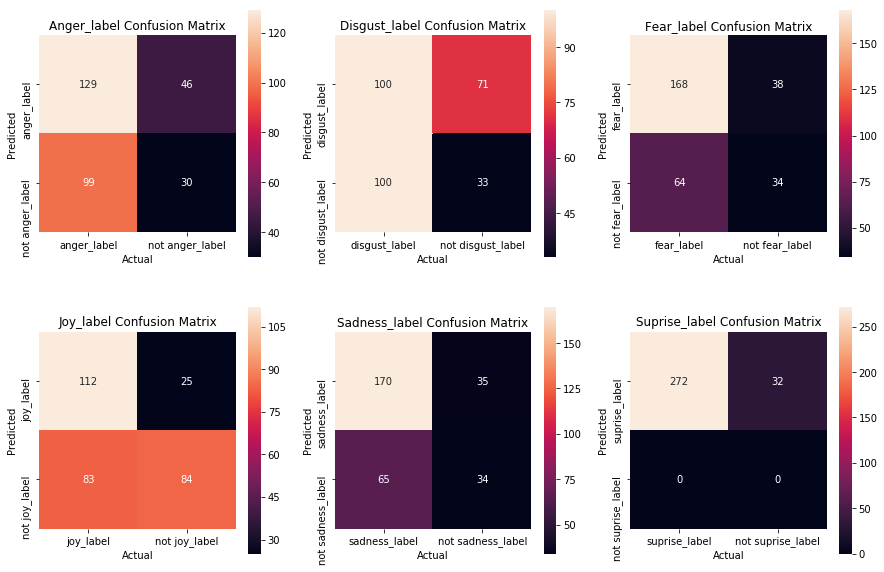

In [56]:
label_scores(emotion_labels, CC_preds_df)

# Recurrent Neural Network

My best model is a Recurrent Neural Network (RNN).

RNN is designed to handle data that is is sequential. When it comes to natural language processing, this is a big advantage over "Bag of Words" and TF-IDF techniques, which can account for the presence of words in a document, but not their order. 

For RNN, I use vector representations of the words in the documents. These vectors represent the euclidain distance between words, determined by a word-to-vector model. A well constructed word-to-vector model can capture relationships between concepts so that, for example, you can subtract the vector representing "France" from "Paris" and then add "Italy" to get "Rome" ([source]('https://code.google.com/archive/p/word2vec/')). 

Instead of training my own word-to-vector model on the same small dataset I'm predicting, I made use of vectors that [Google]('https://code.google.com/archive/p/word2vec/') trained using enormous datasets.

For RNN, I pared back my text preprocessing. I converted words to lower case and remove punctuation (except for exclamation points and question marks), but I did not remove stopwords or lemmatize. 


In [59]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)


In [60]:
# Create vectors
w2v = KeyedVectors.load_word2vec_format('/Users/flatironschool/Desktop/Detecting_Emotions/data/GoogleNews-vectors-negative300.bin',
        binary=True)

# Assign a unique number to each word in the corpus and represents texts via these numbers
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# Add zeros to the end of each sequence as necessary to make them all the same length
padded_data = sequence.pad_sequences(sequences, maxlen=15, padding='post')
       

In [61]:
# Create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# Fill the array with word vectors corresponding to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in w2v.vocab.keys():
        embedding_matrix[ind + 1, :] = w2v[word]
        

In [62]:
# Divide data into training and test sets
random.seed(99)
X_train, y_train, X_test, y_test = iterative_train_test_split(padded_data, emotion_df[emotion_labels].values, test_size=.25)

# Check to see that the labels are evenly divided
print('Percent of each label appreaing in the test set')
print("   Anger:", y_test[:,0].sum()/(y_test[:,0].sum()+y_train[:,0].sum()))
print("   Disgust:", y_test[:,1].sum()/(y_test[:,1].sum()+y_train[:,1].sum()))
print("   Fear:", y_test[:,2].sum()/(y_test[:,2].sum()+y_train[:,2].sum()))
print("   Joy:", y_test[:,3].sum()/(y_test[:,3].sum()+y_train[:,3].sum()))
print("   Sadness", y_test[:,4].sum()/(y_test[:,4].sum()+y_train[:,4].sum()))
print("   Suprise:", y_test[:,5].sum()/(y_test[:,5].sum()+y_train[:,5].sum()))

Percent of each label appreaing in the test set
   Anger: 0.24386503067484663
   Disgust: 0.25333333333333335
   Fear: 0.24634146341463414
   Joy: 0.24936386768447838
   Sadness 0.2421784472769409
   Suprise: 0.24954627949183303


In [63]:
# Build neural network
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))

model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.0025, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train,
                    epochs=50,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 100, 1: 1}, {0: 200, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 50}],
                    validation_data=(X_test, y_test))

Train on 941 samples, validate on 309 samples
Epoch 1/50
941/941 [==============================] - 4s 4ms/step - loss: 0.8148 - acc: 0.5684 - val_loss: 0.6946 - val_acc: 0.6742
Epoch 2/50
941/941 [==============================] - 1s 554us/step - loss: 0.6803 - acc: 0.6364 - val_loss: 0.5942 - val_acc: 0.7114
Epoch 3/50
941/941 [==============================] - 1s 537us/step - loss: 0.6034 - acc: 0.6993 - val_loss: 0.5687 - val_acc: 0.7244
Epoch 4/50
941/941 [==============================] - 1s 563us/step - loss: 0.5636 - acc: 0.7338 - val_loss: 0.5685 - val_acc: 0.7740
Epoch 5/50
941/941 [==============================] - 1s 765us/step - loss: 0.5291 - acc: 0.7506 - val_loss: 0.5992 - val_acc: 0.7540
Epoch 6/50
941/941 [==============================] - 1s 945us/step - loss: 0.4949 - acc: 0.7724 - val_loss: 0.5378 - val_acc: 0.7659
Epoch 7/50
941/941 [==============================] - 1s 1ms/step - loss: 0.4690 - acc: 0.7889 - val_loss: 0.5267 - val_acc: 0.7540
Epoch 8/50
941/941 [

309/309 [==============================] - 0s 221us/step


[0.509319213215973, 0.7734627847146833]

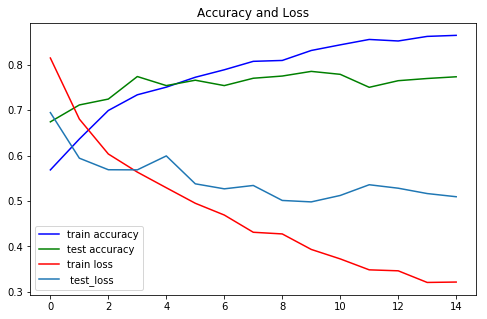

In [64]:
# Plot accuracy and loss for training and test sets
plt.figure(figsize=(8,5))

plt.plot(model.history.history['acc'], color='blue', label='train accuracy')
plt.plot(model.history.history['val_acc'], color='green', label='test accuracy')

plt.plot(model.history.history['loss'], color='red', label='train loss')
plt.plot(model.history.history['val_loss'], label=' test_loss')

plt.title("Accuracy and Loss")
plt.legend()

model.evaluate(X_test, y_test)

In [65]:
# save model 
# model.save('RNN_multiclass_emotion.h5')

# make train predictions
RNN_train_preds = model.predict_on_batch(X_train)

# make test predictions
RNN_test_preds = model.predict_on_batch(X_test)

# make prediction databases
RNN_train_preds_df = pd.DataFrame({"pred_anger_label":RNN_train_preds[:,0], "pred_disgust_label":RNN_train_preds[:,1], "pred_fear_label":RNN_train_preds[:,2], "pred_joy_label":RNN_train_preds[:,3], "pred_sadness_label":RNN_train_preds[:,4], "pred_suprise_label":RNN_train_preds[:,5], "anger_label":y_train[:,0], "disgust_label":y_train[:,1], "fear_label": y_train[:,2], "joy_label": y_train[:,3], "sadness_label": y_train[:,4], "suprise_label": y_train[:,5]})
RNN_test_preds_df = pd.DataFrame({"pred_anger_label":RNN_test_preds[:,0], "pred_disgust_label":RNN_test_preds[:,1], "pred_fear_label":RNN_test_preds[:,2], "pred_joy_label":RNN_test_preds[:,3], "pred_sadness_label":RNN_test_preds[:,4], "pred_suprise_label":RNN_test_preds[:,5], "anger_label":y_test[:,0], "disgust_label":y_test[:,1], "fear_label": y_test[:,2], "joy_label": y_test[:,3], "sadness_label": y_test[:,4], "suprise_label": y_test[:,5]})


In [66]:
# Get RNN Train Scores
overall_scores(y_train, RNN_train_preds>.5)


jaccard score macro: 0.844
hamming loss: 0.101
f1 macro: 0.914


In [67]:
# Get RNN Test Scores
overall_scores(y_test, RNN_test_preds>.5)


jaccard score macro: 0.673
hamming loss: 0.227
f1 macro: 0.798


anger_label accuracy: 0.3592233009708738
anger_label precision: 0.7872340425531915
anger_label recall 0.6981132075471698
anger_label f1 0.74


disgust_label accuracy: 0.23300970873786409
disgust_label precision: 0.7659574468085106
disgust_label recall 0.5413533834586466
disgust_label f1 0.6343612334801761


fear_label accuracy: 0.5566343042071198
fear_label precision: 0.7926267281105991
fear_label recall 0.8514851485148515
fear_label f1 0.8210023866348448


joy_label accuracy: 0.5663430420711975
joy_label precision: 0.7641921397379913
joy_label recall 0.8928571428571429
joy_label f1 0.8235294117647058


sadness_label accuracy: 0.5792880258899676
sadness_label precision: 0.817351598173516
sadness_label recall 0.8564593301435407
sadness_label f1 0.8364485981308413


suprise_label accuracy: 0.8705501618122977
suprise_label precision: 0.890728476821192
suprise_label recall 0.9781818181818182
suprise_label f1 0.9324090121317159




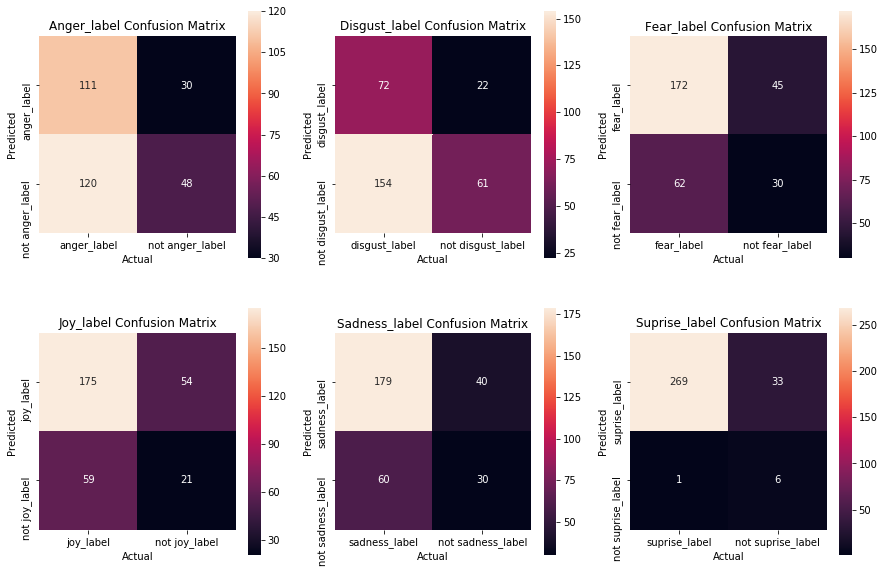

In [68]:
# Get RNN Label Scores 
label_scores(emotion_labels, RNN_test_preds_df, RNN=True)
